    


<h2 style="color:#4A235A" >Supply Chain Analytics</h2>
---

<img src="images/Walmart_logo.png" alt="logo" style="width: 200px;float:right"/>



presented by:
    - Sunil PRAKASH
    - Gaelan GU
    - Abhilasha K
    - JiaYi LEE
    - Ashok EAPEN
    

<link rel="stylesheet" type="text/css" href="./custom.css">

## Agenda

- Demand Forecasting
- Inventory Management
- Warehouse Optimization
- Network Planning
- Reverse Logistics

#### Demand Forecasting



<img src="images/wallmart_df_1.jpg"  style="width: 300px;float:right"/>

### Background

- Important to forecast sales for business planning purposes
- Overestimation leads to surplus of goods and underestimation creates a potential stockout situation
- Forecasts are not always correct - but in Walmart's case, seasonality can easily be accounted for
- Net sales figures in millions extracted from Walmart's quarterly reports from FY 2010 to 2018



In [1]:
from IPython.html.services.config import ConfigManager
from IPython.utils.path import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'serif',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: locate_profile has moved to the IPython.paths module since IPython 4.0.
  This is separate from the ipykernel package so we can avoid doing imports until


{u'start_slideshow_at': 'selected', u'theme': 'serif', u'transition': 'zoom'}

In [2]:
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact 
%matplotlib inline

df = pd.read_csv('demand_forecasting/walmart_rev.csv')

split_ix = 28
train_ix = range(0, 28)
test_ix = range(28, 34)

ts = pd.Series(df['revenue_millions'])
train = pd.Series(df['revenue_millions'][:split_ix], index=train_ix)
test = pd.Series(df['revenue_millions'][split_ix:], index=test_ix)



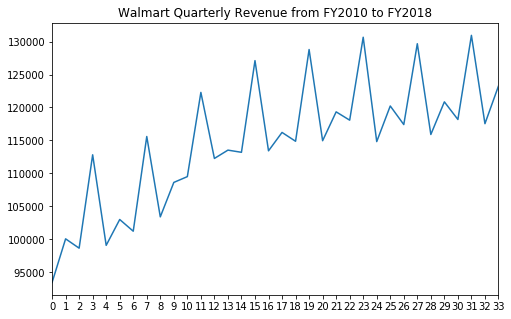

Increasing trend seems to occur within this time period


In [3]:
ts.plot(figsize=(8,5), title='Walmart Quarterly Revenue from FY2010 to FY2018')
plt.xticks(range(0, 34, 1))
plt.show()
print("Increasing trend seems to occur within this time period")



* **Increasing** trend seems to occur within this time period
    - Begins to plateau around start of FY 2015

* **Strong** seasonality pattern due to expected consumer behaviour which happens throughout the year
    - e.g. Events in Q4 like Black Friday, Christmas and New Year's



In [4]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exp_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result



# @interact
# def forecast_stocks(period=4):
#     return triple_exp_smoothing(ts, 4, 0.1, 0.5, 0.9, period)

In [5]:
from sklearn.metrics import mean_absolute_error
es3 = triple_exp_smoothing(train, 4, 0.1, 0.5, 0.9, 6)
es3_test = pd.Series(es3[split_ix:], index=test_ix)
es3_mae = mean_absolute_error(test, es3_test)
print('The MAE for triple exponential smoothing on the test set is %.2f' %es3_mae)

from sklearn.metrics import mean_squared_error
es3_mse = mean_squared_error(test, es3_test)
print('The MSE for triple exponential smoothing on the test set is %.2f' %es3_mse)


The MAE for triple exponential smoothing on the test set is 458.33
The MSE for triple exponential smoothing on the test set is 409901.11


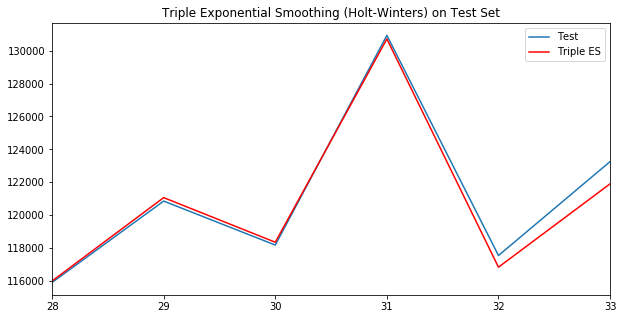

In [6]:
test.plot(figsize=(10,5), label='Test', legend=True)
es3_test.plot(figsize=(10,5), color='r', label='Triple ES', legend=True)
plt.title('Triple Exponential Smoothing (Holt-Winters) on Test Set')
plt.show()

In [15]:
%matplotlib inline

@interact
def forecast_stocks(period=4):
    es3_p = triple_exp_smoothing(ts, 4, 0.1, 0.5, 0.9, period)
    es3_p = pd.Series(es3_p)
    ts.plot(figsize=(10,5), color='b', label='actual', legend=True)
    es3_p[33:].plot(figsize=(10,5), color='r', label='predicted', legend=True)
    plt.xticks(range(0, 37, 1))
    plt.title("Forecasted Demand for Walmart's Next 4 Quarters")
    #plt.show()

interactive(children=(IntSlider(value=4, description=u'period', max=12, min=-4), Output()), _dom_classes=('widget-interact',))

### Warehouse and Inventory

Data Distribution

<img src="images/shipment.png" style="z-index:-20;width:100%;padding-top:-20px"/>

Economic order quantity (EOQ) is an equation for inventory that determines the ideal order quantity a company should purchase for its inventory given a set cost of ordering, demand rate and other variables. This is done to minimize variable inventory costs, and the formula takes into account storage, or holding, costs, ordering costs and shortage costs.

<img src="inventory_management/Economic-Order-Quantity-Graph_v2.png" style="width: 400px;float:right"/>
##### Economic Order Quantity Formula
$$ EOQ = \sqrt{\frac{2OD}{CI}}$$
* O = Ordering Costs
* D = Annual Demand rate
* C = Unit Costs
* I = Holding rate (% per year)

In [8]:
import pandas as pd
%matplotlib notebook
import math



parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='coerce')
df_inventory = pd.read_csv('inventory_management/footwear_inventory_dataset.csv', index_col=['Unnamed: 0'], parse_dates=['ARRIVAL DATE'], date_parser=parser)

df_inventory['YEAR'] = df_inventory['ARRIVAL DATE'].dt.year
filtered_df = df_inventory[df_inventory['YEAR'] == 2013]
annual_demand = filtered_df['QUANTITY'].sum()
print ("Calculated annual demand is ",annual_demand)
EOQ=10480

('Calculated annual demand is ', 549179)


Assuming
* O = \$100
* C = \$10
* I = 10%

In [9]:
@interact
def eoq_optimization(order=100,cost=10,interest=10):
    if order>0 and cost>0 and interest>0:
        EOQ = int(math.sqrt((2*order*annual_demand)/(cost*interest/100.)))
        print ("Economic Order Quantity is",EOQ)
    else:
        print("Values cannot be -ve")


interactive(children=(IntSlider(value=100, description=u'order', max=300, min=-100), IntSlider(value=10, description=u'cost', max=30, min=-10), IntSlider(value=10, description=u'interest', max=30, min=-10), Output()), _dom_classes=('widget-interact',))


<small>
The re-order point (ROP) is the level of inventory which triggers an action to replenish that particular inventory stock. It is a minimum amount of an item which a firm holds in stock, such that, when stock falls to this amount, the item must be reordered. It is normally calculated as the forecast usage during the replenishment lead time plus safety stock.
</small>

<img src="inventory_management/reorder_point.jpg" style="width: 400px;float:right"/>
<small >
Reorder Point = Demand during lead-time + Safety Stock

    ROP = LTU + SS

        = LTC + K(σ)
    
    where

        k = safety factor

        σ = standard deviation over lead time
 </small>


 <small >
 Demand during Lead Time
* Total requirement for an item in the lead time

    LTU = LT x Usage rate
    
Setting Safety Stock
* Lead time is not accurately known and demand cannot be
predicted exactly
* Safety Stock (SS) is the product of the standard deviation over
the lead time and the safety factor K

    SS = K(σ)
 
 Number of order/year (N) = Annual demand/EOQ
 
</small>

In [10]:
N = annual_demand/EOQ
print "Therefore the number of order/year is {}".format(N)

P = ((1)*EOQ)/float(annual_demand)
print "Therefore the probability of stock shortage is {:.1%}".format(P)

Therefore the number of order/year is 52
Therefore the probability of stock shortage is 1.9%


<small>
From the **normal distribution** table

k = 2.0

Assuming standard deviation over lead time as

σ = 300

Assuming demand during lead time as

LTU = 1000

Hence 

SS = K(σ) = 2.0(300) = 600

ROP = LTU + SS = 1000 + 600 
    = **1600**
</small>

Warehouse Optimization

<img src="images/warehouse_1.png" style="float:right"/>
### BACKGROUND

<small>
- Operational excellence is one key strategies of walmart   
- Wants to reduce the number of operational  distribution centre's(dc) in the regions  where profit margin is less than 12% 
- Minnesota is identified of the  non profit making regions
- Minnesota region has 5 dc's and 4 stores
- Each dc has fixed capacity
- Each store different demands
- There is fixed cost associated with each  dc and  also there is transportation cost associated with  shipping  goods from  each dc to each store
- DC are  dc0 ,dc1,dc2,dc3
- Stores are store0,store1,store2,store3,store4

</small>    


##### Logical  Constraints
- Products shipped from the dc  to store  must be >= 0
- The products shipped  can not exceed the capacity of the dc and the number shipped should meet the demand of the store
products_stored<= capacity	 	 	 	 
 total_shipped >= demand
a DC must be open to  ship  goods to store

##### Objective  
To  Minimize the Overall Operating Cost



Data

<img src="images/warehouse_2.png" style="float:left"/>
<img src="images/warehouse_3.png" style="float:left"/>
<img src="images/warehouse_4.png" style="float:right"/>

### SOLUTION
- the optimal solution was found  using  the gurobi optimization tools facity model
- the optimal  operating cost was found to be $212700 

- the operational cost was reduced by $12000 
- DC 2 and 4 needs to be cost
- new  optimal model is able to  all store demands with 3 DC's


<img src="images/warehouse_5.png" style="float:left"/>
<img src="images/warehouse_6.png" style="float:left"/>
<img src="images/warehouse_7.png" style="float:right"/>

### Network and Route Planning

### Objective : 

- To find shortest route to optimize the Utilization 
- Shortest Route from to warehouse to all distribution centers was Found
- Distribution Center And WareHouse dataset Of USA
- Vehicle Routing Problem, Best possible route was found

<span>
<img src="images/routing_1.png" alt="logo" style="width: 200px height:100px;float:left"/> &nbsp;
<img src="images/routing_2.png" alt="logo" style="width: 200px height:100px; float:right; margin-top:5px"/>
</span>

- But ,in real life routing just not depends on the shortest route
- challenge is to find the most optimal route with given constraints
- which should increase the utilization of vehicle and thus serving the objective
- simulation to show process optimization 

<span>
<img src="images/routing_3.png" alt="logo" style="width: 200px height:100px;float:left"/> &nbsp;
<img src="images/routing_4.png" alt="logo" style="width: 200px height:100px; float:right; margin-top:5px"/>
</span>


- shows scenarios like trucks from warehouse going to the Distribution centers
- waits till the time packing / unpacking is done then moves back to the warehouse
- then to maximize the utilization of vehicles in the route we run optimization model 
- optimal no of trucks to be used in this route is 6 ,  
- we are using 10, 4 vehicles can be used in other operations

<span>
<img src="images/routing_5.png" alt="logo" style="width: 200px height:100px;float:left"/> &nbsp;
<img src="images/routing_6.png" alt="logo" style="width: 200px height:100px; float:right; margin-top:5px"/>
</span>




<video controls src="images/final_recording.mov" />


### Reverse Logistic

<img src="images/rev_1.png" alt="routing" style="width: 400px;  float:right; margin-bottom:10px"/>

In [11]:

from __future__ import print_function
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# Travelling Time callback
class CreateTravellingTimeCallback(object):
    """Create callback to calculate travelling time between points."""

    def __init__(self):
        """Array of time taken between points to travel"""

        # travelling time in minutes
        self.time_matrix = [
            [0,  26, 16, 10, 9,	 10,  8, 20, 14, 20], # Allegheny Center
            [26, 0,	 18, 24, 26, 28,  2, 22, 30, 24], # Lincoln Place
            [16, 18, 0,	 7,	 9,	 14,  1, 16, 16, 20], # North Oakland
            [10, 24, 7,	 0,	 3,	 10,  4, 16, 12, 18], # Wexford
            [9,	 26, 9,	 3,	 0,	 10,  4, 16, 12, 16], # South Oakland
            [10, 28, 14, 10, 10,  0,  1, 16, 4,	 24], # Terrace Village
            [8,	 26, 10, 4,	 4,	 10,  0, 18, 12, 18], # Highland Park
            [20, 22, 16, 16, 16, 16,  18, 0, 22, 35], # Fairywood
            [14, 30, 16, 12, 12, 4,	  12, 22, 0, 26], # Deutschtown
            [20, 24, 20, 18, 16, 24,  18, 35, 26, 0], # Brookline
        ]

    def TravelTime(self,from_node, to_node):
        return self.time_matrix[from_node][to_node]

# Time Spend at location Callback (time in minutes)
class CreateTimeSpendAtLocationCallback(object):
    """Create callback to get time to be spent at each location"""

    def __init__(self, durations):
        self.matrix = durations

    def ExplorationTime(self, node):
        return self.matrix[node]

class CreateMoneySpendAtLocationCallback(object):
    """Create callback to get time to be spent at each location"""

    def __init__(self, locations):
        self.matrix = locations

    def Cost(self, node,second):
        return self.matrix[node]

class CreateTotalTimeCallback(object):
    """Create callback to get total times between locations"""

    def __init__(self,exploration_time_callback, travel_time_callback):
        self.exploration_time_callback = exploration_time_callback
        self.travel_time_callback = travel_time_callback

    def TotalTime(self, from_node, to_node):
        exploration_time = self.exploration_time_callback(from_node)
        travel_time = self.travel_time_callback(from_node, to_node)
        return exploration_time + travel_time

def main_routing(num_routes=3,depot=6,time_window=12):

    # locations
    location_names = ['Allegheny Center','Lincoln Place','North Oakland','Wexford','South Oakland','Terrace Village',
                        'Highland Park','Fairywood','Deutschtown','Brookline']

    # weights (time in minutes)
    location_weights = [120,120,60,60,120,240,30,60,120,60] # minimum time required to spend at each location
    location_ticket_costs = [30,66,30,10,10,80,1,20,50,10]

    l_size = len(location_names)
    # The number of routes
    #num_routes = 3

    # Nodes are indexed from 0 to l_size - 1.
    # The depot is the stating node of the route

    #depot = 6


    # Creating model
    if l_size > 0:
        routing = pywrapcp.RoutingModel(l_size,num_routes,depot)
        search_parameters  = pywrapcp.RoutingModel.DefaultSearchParameters()

        search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        exploration_times = CreateTimeSpendAtLocationCallback(location_weights)
        exploration_time_callback = exploration_times.ExplorationTime

        travel_times = CreateTravellingTimeCallback()
        travel_time_callback = travel_times.TravelTime

        total_times = CreateTotalTimeCallback(exploration_time_callback,travel_time_callback)
        total_time_callback = total_times.TotalTime

        money_costs = CreateMoneySpendAtLocationCallback(location_ticket_costs)
        money_cost_callback = money_costs.Cost

        # time dimension , minutes in scale, max available time 12hrs
        horizon = time_window * 60 *1 # 12hrs * 60 minutes
        fix_start_cumul_to_zero = False
        time = "Time"
        money = "Money"

        routing.SetArcCostEvaluatorOfAllVehicles(travel_time_callback)
        #routing.SetFixedCostOfAllVehicles(horizon)


        routing.AddDimension(total_time_callback,horizon,horizon,fix_start_cumul_to_zero, time)

        max_budget = 1000
        routing.AddDimension(money_cost_callback, max_budget, max_budget, fix_start_cumul_to_zero, money)
        routing.AddVariableMinimizedByFinalizer(routing.CumulVar(0, money));

        #  add cost constrains - TBD

        print("trying to find solution", routing.GetCostClassesCount())
        # Solve and print solutions if any
        possible_plan = routing.SolveWithParameters(search_parameters)

        if possible_plan:
            size = len(location_names)

            # Solution Cost
            print("Total time of all paths: " + str(possible_plan.ObjectiveValue()) + "\n")

            # Inspect Solution
            time_dimension = routing.GetDimensionOrDie(time)
            cost_dimension = routing.GetDimensionOrDie(money)

            #print("size is", size)

            for location in range(num_routes):
                #print("starting..",location)
                index = routing.Start(location)
                plan_output = 'Route {0}: '.format(location)


                while not routing.IsEnd(index):
                    #print(".. still trying",index)
                    if index < 0:
                        break
                    node_index = routing.IndexToNode(index)
                    time_var = time_dimension.CumulVar(index)
                    cost_var = cost_dimension.CumulVar(index)
                    plan_output += \
                                "{node_index} Time({tmin},{tmax}) Cost({cmin},{cmax}) -> ".format(
                                    node_index=location_names[node_index],
                                    tmin=str(possible_plan.Min(time_var)),
                                    tmax=str(possible_plan.Max(time_var)),
                                    cmin=str(possible_plan.Min(cost_var)),
                                    cmax=str(possible_plan.Min(cost_var)),
                                )
                    index = possible_plan.Value(routing.NextVar(index))

                node_index = routing.IndexToNode(index)
                time_var = time_dimension.CumulVar(index)
                plan_output += \
                                "{node_index} Time({tmin},{tmax}) -> ".format(
                                    node_index=location_names[node_index],
                                    tmin=str(possible_plan.Min(time_var)),
                                    tmax=str(possible_plan.Max(time_var))
                                )

                print(plan_output)
                print("\n")
            #print("all done")

        else:
            print("No Solution found")


Optimal Route?
<img src="images/routing_11.png" alt="routing" style="width: 100%; height:100%; float:right; margin-bottom:10px"/>

In [18]:
@interact
def calculate_optimal_route(num_routes=3,depot=6,time_window=12):
    if num_routes>0 and (depot>-1 and depot<10) and time_window>0:
        main_routing(num_routes,depot,time_window) 
    

interactive(children=(IntSlider(value=3, description=u'num_routes', max=9, min=-3), IntSlider(value=6, description=u'depot', max=18, min=-6), IntSlider(value=12, description=u'time_window', max=36, min=-12), Output()), _dom_classes=('widget-interact',))

Showing the routes

In [13]:
m=folium.Map(
    location=[1.366395, 103.806181],
    tiles='Stamen Toner',
    zoom_start=12
)

In [14]:
#m

Thank you ヾ(-_- )ゞ

<small>
   *"You Don't Know What You Don't Know"*
</small>
 